**Machine Learning Application**

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('obesity_data_with_status_50000.csv')

In [17]:
label_encoder = LabelEncoder()
df['Obesity_Status'] = label_encoder.fit_transform(df['Obesity_Status'])
df['Blood_Pressure'] = label_encoder.fit_transform(df['Blood_Pressure'])

def remove_outliers_zscore(df, column_names, threshold=3):
    z_scores = np.abs((df[column_names] - df[column_names].mean()) / df[column_names].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

continuous_columns = ['Height_cm', 'Weight_kg']
df_cleaned = remove_outliers_zscore(df, continuous_columns)

In [18]:
scaler = StandardScaler()
df_cleaned[['Height_cm', 'Weight_kg']] = scaler.fit_transform(df_cleaned[['Height_cm', 'Weight_kg']])

In [19]:
# Feature-target split
X = df_cleaned.drop('Obesity_Status', axis=1)
y = df_cleaned['Obesity_Status']

# Train-validation-test split (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [25]:
# 1. Logistic Regression with hyperparameter tuning
log_reg_params = {
    'C': [0.01, 10, 100,200,300],
    'solver': ['liblinear', 'lbfgs']
}
log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=5, scoring='accuracy')
log_reg.fit(X_train, y_train)
y_val_pred_log_reg = log_reg.predict(X_val)
print(f"Logistic Regression Best Params: {log_reg.best_params_}")
print(f"Logistic Regression Validation Accuracy: {accuracy_score(y_val, y_val_pred_log_reg)}")

Logistic Regression Best Params: {'C': 100, 'solver': 'liblinear'}
Logistic Regression Validation Accuracy: 0.9425067846014675


In [26]:
# 2. Random Forest with hyperparameter tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy')
rf_model.fit(X_train, y_train)
y_val_pred_rf = rf_model.predict(X_val)
print(f"Random Forest Best Params: {rf_model.best_params_}")
print(f"Random Forest Validation Accuracy: {accuracy_score(y_val, y_val_pred_rf)}")

Random Forest Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Validation Accuracy: 1.0


In [27]:
# 3. SVM with hyperparameter tuning
svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf','poly']
}
svm_model = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy')
svm_model.fit(X_train, y_train)
y_val_pred_svm = svm_model.predict(X_val)
print(f"SVM Best Params: {svm_model.best_params_}")
print(f"SVM Validation Accuracy: {accuracy_score(y_val, y_val_pred_svm)}")

SVM Best Params: {'C': 100, 'kernel': 'linear'}
SVM Validation Accuracy: 0.9991958990853352


In [28]:
# 4. XGBoost with hyperparameter tuning
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}
xgb_model = GridSearchCV(XGBClassifier(), xgb_params, cv=5, scoring='accuracy')
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)
print(f"XGBoost Best Params: {xgb_model.best_params_}")
print(f"XGBoost Validation Accuracy: {accuracy_score(y_val, y_val_pred_xgb)}")

XGBoost Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
XGBoost Validation Accuracy: 0.9974871846416725


In [31]:
# Final evaluation on the test set
print("\n--- Final Test Accuracy ---")
y_test_pred_log_reg = log_reg.predict(X_test)
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_test_pred_log_reg)}")

y_test_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_test_pred_rf)}")

y_test_pred_svm = svm_model.predict(X_test)
print(f"SVM Test Accuracy: {accuracy_score(y_test, y_test_pred_svm)}")

y_test_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_test_pred_xgb)}")


--- Final Test Accuracy ---
Logistic Regression Test Accuracy: 0.9396924314001407
Random Forest Test Accuracy: 1.0
SVM Test Accuracy: 0.9991958990853352
XGBoost Test Accuracy: 0.9983917981706704


**Deep Learning Application**

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [11]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=4.), metrics=['accuracy'])

# Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(X_train, tf.keras.utils.to_categorical(y_train, num_classes=4),
                    epochs=50, batch_size=32,
                    validation_data=(X_test, tf.keras.utils.to_categorical(y_test, num_classes=4)),
                    callbacks=[early_stopping, lr_reduction])

Epoch 1/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3999 - loss: 1.5859 - val_accuracy: 0.7830 - val_loss: 0.1634 - learning_rate: 0.0010
Epoch 2/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7174 - loss: 0.2154 - val_accuracy: 0.8942 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 3/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8246 - loss: 0.1172 - val_accuracy: 0.8886 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 4/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8653 - loss: 0.0865 - val_accuracy: 0.9519 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 5/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8911 - loss: 0.0719 - val_accuracy: 0.9446 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 6/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9046 - loss: 0.0621 - val_accuracy: 0.9555 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 7/50
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9129 -

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,694 (123.81 KB)

 Trainable params: 10,564 (41.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,130 (82.54 KB)

In [13]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.2 MB/s eta 0:00:00


In [14]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score

tabnet_model = TabNetClassifier()

tabnet_model.fit(X_train.values, y_train.values,
                 max_epochs=100,
                 patience=10,
                 batch_size=1024,
                 virtual_batch_size=128,
                 num_workers=0,
                 drop_last=False)

y_pred_tabnet = tabnet_model.predict(X_test.values)

print(f"TabNet Accuracy: {accuracy_score(y_test, y_pred_tabnet)}")

epoch 0  | loss: 0.9369  |  0:00:03s
epoch 1  | loss: 0.23586 |  0:00:09s
epoch 2  | loss: 0.16815 |  0:00:16s
epoch 3  | loss: 0.18545 |  0:00:19s
epoch 4  | loss: 0.14111 |  0:00:24s
epoch 5  | loss: 0.13546 |  0:00:28s
epoch 6  | loss: 0.13685 |  0:00:30s
epoch 7  | loss: 0.13193 |  0:00:32s
epoch 8  | loss: 0.1192  |  0:00:34s
epoch 9  | loss: 0.12176 |  0:00:35s
epoch 10 | loss: 0.13287 |  0:00:37s
epoch 11 | loss: 0.11713 |  0:00:39s
epoch 12 | loss: 0.10921 |  0:00:41s
epoch 13 | loss: 0.12401 |  0:00:42s
epoch 14 | loss: 0.11624 |  0:00:44s
epoch 15 | loss: 0.12079 |  0:00:45s
epoch 16 | loss: 0.13533 |  0:00:47s
epoch 17 | loss: 0.10477 |  0:00:48s
epoch 18 | loss: 0.11522 |  0:00:51s
epoch 19 | loss: 0.09552 |  0:00:52s
epoch 20 | loss: 0.09913 |  0:00:54s
epoch 21 | loss: 0.10336 |  0:00:55s
epoch 22 | loss: 0.11379 |  0:00:57s
epoch 23 | loss: 0.09909 |  0:00:58s
epoch 24 | loss: 0.10058 |  0:01:00s
epoch 25 | loss: 0.09714 |  0:01:02s
epoch 26 | loss: 0.09299 |  0:01:04s
e

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model Comparison:
                     Accuracy
Logistic Regression  0.896673
Random Forest        1.000000
SVM                  0.998191
XGBoost              0.997487
Deep Learning Model  0.994673
TabNet               0.993768


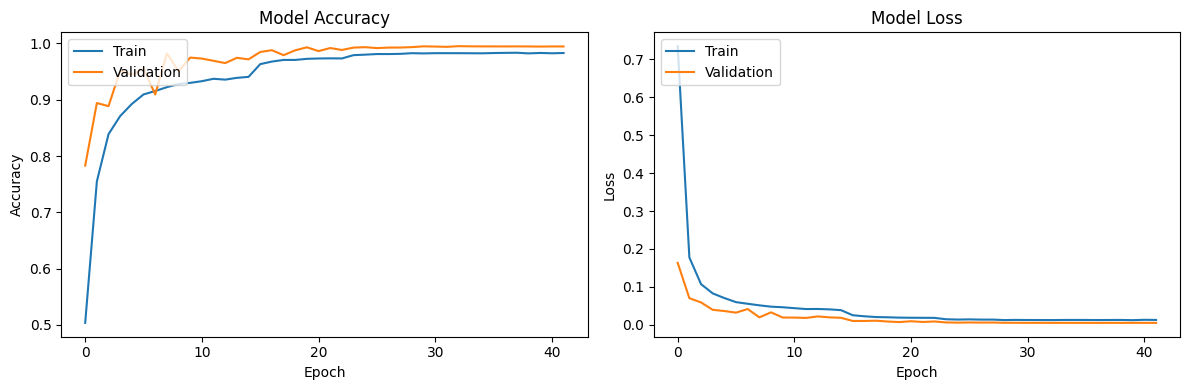

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

model_results = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log_reg),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'XGBoost': accuracy_score(y_test, y_pred_xgb),
    'Deep Learning Model': accuracy_score(y_test, np.argmax(model.predict(X_test), axis=1)),
    'TabNet': accuracy_score(y_test, y_pred_tabnet)
}

results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['Accuracy'])
print("Model Comparison:")
print(results_df)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()